itr 14: if_connected=True, D=136


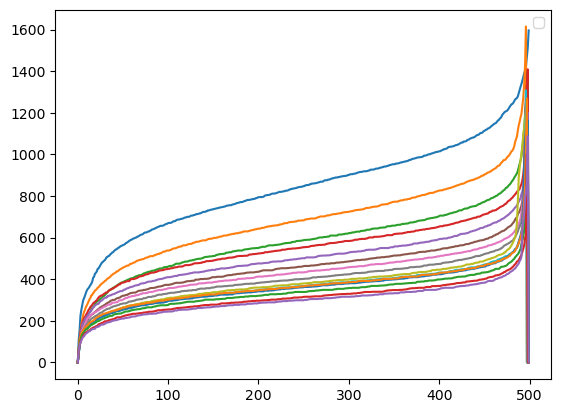

In [2]:
import random
import networkx as nx
import torch as th
import pickle as pkl
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def directed_to_undirected(directed_graph, method='sum'):
    undirected_graph = nx.Graph()
    
    for u, v, data in directed_graph.edges(data=True):
        weight_uv = data['weight']
        
        if undirected_graph.has_edge(u, v):
            existing_weight = undirected_graph[u][v]['weight']
            
            if method == 'sum':
                new_weight = existing_weight + weight_uv
            elif method == 'average':
                new_weight = (existing_weight + weight_uv) / 2
            elif method == 'max':
                new_weight = max(existing_weight, weight_uv)
            elif method == 'min':
                new_weight = min(existing_weight, weight_uv)
            else:
                raise ValueError("Method must be one of 'sum', 'average', 'max', 'min'")
            
            undirected_graph[u][v]['weight'] = new_weight
        else:
            undirected_graph.add_edge(u, v, weight=weight_uv)
    
    return undirected_graph

def initialize_graph(N, K, if_random_ring=False, latency=None):
    graph = nx.DiGraph()
    graph.add_nodes_from(range(N))
    if latency is None:
        latency = nx.complete_graph(N)
        for (u, v) in latency.edges():
            # latency.edges[u,v]['weight'] = random.randint(1, 10)  # Assign random positive weights
            latency.edges[u,v]['weight'] = random.randint(1, 100)  # Assign random positive weights
            # test_graph.edges[u, v]['weight'] = np.random.normal(self.mean, self.std_dev)
        for (u, v) in latency.edges():
            latency.edges[v,u]['weight'] = latency.edges[u,v]['weight']  # Assign random positive weights
    for i in range(N):
        connections = random.sample([j for j in range(N) if j != i], K)
        for j in connections:
            graph.add_edge(i, j, weight=latency.edges[i, j]['weight'])
    random_ring = None
    if if_random_ring:
        nodes = list(graph.nodes())
        random.shuffle(nodes)

        random_ring = {}
        # Connect each node to the next in the shuffled list, making a ring
        for i in range(len(nodes)):
            graph.add_edge(nodes[i], nodes[(i + 1) % len(nodes)], weight=latency.edges[nodes[i], nodes[(i + 1) % len(nodes)]]['weight'])
            random_ring[nodes[i]] = nodes[(i + 1) % len(nodes)]
    return graph, latency, random_ring

def update_graph( graph, latency, random_ring, N, K, M, sample_sources=3, if_diameter_directed=False, max_iterations=20):
    previous_diameter = 0
    try:
        previous_diameter = nx.diameter(graph, weight='weight')
    except:
        largest_cc = max(nx.strongly_connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc)
        previous_diameter = nx.diameter(subgraph)
    # main loop to update the graph
    # Step 1: Randomly select 3 source nodes
    
    a = th.zeros(max_iterations, N)
    
    plt.figure()
    fig, ax = plt.subplots()
    ax.legend()
    x = [i for i in range(N)]
    sources = random.sample(graph.nodes(), sample_sources)
    for itr in range(max_iterations):
        # Step 2: Compute the shortest paths from these sources
        all_paths_lengths = []
        for source in sources:
            lengths = nx.single_source_dijkstra_path_length(graph, source)
            all_paths_lengths.append(lengths)
            a[itr][:len(list(lengths.values()))] += th.as_tensor(list(lengths.values()))
            # assert 0
        successor = []
        for node in range(N):
            if random_ring is not None:
                successor.append( [ i for i in graph.successors(node) if i != random_ring[node]] )
            else:
                successor.append( [ i for i in graph.successors(node)] )
            # # successors = list(graph.successors(node))
            # print(list(graph.successors(node)))
            # assert 0
        # Step 3: Update scores (example update mechanism)
       
        scores = th.zeros(N, K)
        for lengths in all_paths_lengths:
            # if len(successor[node]) >= K - 2:
            for node in range(N):
                neighbor_lengths = th.as_tensor([(latency.edges[neighbor, node]['weight'] + lengths.get(neighbor, float('inf'))) for neighbor in successor[node]])
                neighbor_lengths = neighbor_lengths - lengths.get(node, float('inf'))
                scores[node][:len(successor[node])] += th.as_tensor(neighbor_lengths)

        # Step 2: Find the corresponding outgoing connected nodes id
        # selected_neighbors = [[successor[i][idx] for idx in top2_indices[i]] for i in range(N)]
        remaining_neighbors = []
        for i in range(N):
            top2_scores, top2_indices = th.topk(scores[i][:len(successor[i])], 2, dim=0)
            # print(top2_indices)
            selected_neighbor = [successor[i][idx] for idx in top2_indices]
            
            for j in range(2):
                # graph.edges[i, selected_neighbors[i][j]]['weights'] = 0
                graph.remove_edge(i, selected_neighbor[j])
                
            remaining_neighbors.append(
                [n for j, n in enumerate(successor[i]) if j not in top2_indices]
            )
            
        # Step 3: Drop the selected two outgoing connections
        # Assume 'dropping' means we don't consider these for the next step of reconnection

        # Step 4: Randomly select two new nodes as new outgoing connections
        # Ensuring that the newly selected nodes are not the same as any current ones
        for i in range(N):
            new_connections = []
            potential_new_connections = set(range(N)) - set(remaining_neighbors[i]) - set([i])
            # print(new_connections)
            # assert 0
            new_connections = random.sample(potential_new_connections, K - len(remaining_neighbors[i]))
            for j in range(K - len(remaining_neighbors[i])):
                graph.add_edge(i, new_connections[j], weight=latency.edges[i, new_connections[j]]['weight'])
        # Step 5: Check and drop incoming connections if necessary
        for node in graph.nodes():
            if graph.in_degree(node) > M:
                excess_connections = graph.in_degree(node) - M
                # print( list(graph.in_edges(node)))
                # assert 0
                if random_ring is not None:
                    incoming_edges = [(i, node) for (i, j) in graph.in_edges(node) if node != random_ring[i]]
                else:
                    incoming_edges = list(graph.in_edges(node))
                edges_to_drop = random.sample(incoming_edges, excess_connections)
                graph.remove_edges_from(edges_to_drop)

        # Step 4: Check termination condition
        
        if if_diameter_directed:
            if_connected = nx.is_strongly_connected(graph)
            g = graph
        else:
            undirected_graph = directed_to_undirected(graph, method='average')
            if_connected = nx.is_strongly_connected(graph)
            g = undirected_graph
        try:
            current_diameter = nx.diameter(g, weight='weight')
        except:
            if if_diameter_directed:
                largest_cc = max(nx.strongly_connected_components(g), key=len)
            else:
                largest_cc = max(nx.connected_components(g), key=len)
            subgraph = g.subgraph(largest_cc)
            current_diameter = nx.diameter(subgraph, weight='weight')
        # if current_diameter == previous_diameter:
        #     print("Termination condition met: Diameter unchanged.")
        #     break
        print(f"itr {itr}: if_connected={if_connected}, D={current_diameter}")
        y = a[itr].numpy()
        ax.plot(x, y, label=itr)
        plt.show()
        display(fig)
    
        # Clear the output for the next plot
        clear_output(wait=True)
        time.sleep(0.5)
        previous_diameter = current_diameter
    return a


if __name__ == '__main__':
    # Parameters and graph initialization
    N = 500  # Number of nodes
    K = 8   # Outgoing connections per node
    M = 10 # Maximum incoming connections per node
    num_tests = 1
    max_iterations = 3000
    sample_sources = 10
    for i in range(num_tests):
        # graph_name = f'N={N}_{i}_Gaussian.pkl'
        graph_name = f'N={N}_{i}.pkl'
        with open(os.path.join('.', 'test_dataset', graph_name), 'rb') as f:
            G = pkl.load(f)

        # graph, latency, random_ring = initialize_graph(N, K, if_random_ring=False, latency=G)
        graph, latency, random_ring = initialize_graph(N, K, if_random_ring=False, latency=None)

        # Compute scores
        data = update_graph(graph, latency, random_ring, N, K, M, sample_sources=sample_sources, if_diameter_directed=True, max_iterations=max_iterations)
        
        plt.figure()
        fig, ax = plt.subplots()
        x = [j for j in range(N)]
        for j in range(max_iterations):
            y = data[j].numpy()
            ax.plot(x, y)
        # ax.legend()
        fig.savefig(f'N={N}_{i}_Gaussian.png')
        

<Figure size 640x480 with 0 Axes>

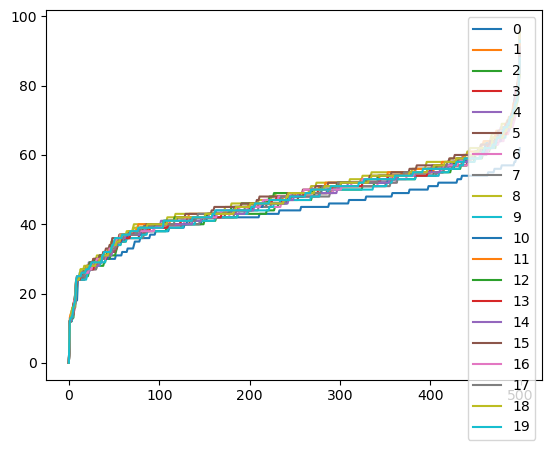

In [ ]:
plt.figure()
fig, ax = plt.subplots()
x = [i for i in range(N)]
for i in range(max_iterations):
    y = data[i].numpy()
    ax.plot(x, y, label=i)
ax.legend()
fig.savefig(f'N={N}_{i}_Gaussian.png')
